# Avaliação Prática parte 2

## Importações

In [ ]:
!pip install requests

In [ ]:
# Import libraries
import numpy as np
from PIL import Image, ImageOps  # Install pillow instead of PIL
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False
import json
import sys
import io

# Import tensorflow and keras libraries
import tensorflow as tf
from keras.models import load_model  # TensorFlow is required for Keras to work

## Funções Úteis

In [ ]:
# Preprocess image so that it can be inputted to MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  # image = tf.image.resize(image, (224, 224))
  image = tf.image.resize(image, (720, 720))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Load and preprocess image
def loadAndPreprocessImage(image_path):
  image = Image.open(image_path)
  image = image.convert("RGB")
  # image = preprocess(image)
  return image

# Print image and its class and score if they exist
def printImage(image, class_name=None, confidence_score=None, eps=None, preprocessed=False):
  image = preprocess(image) if not preprocessed else image
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
  if((class_name == None) and (eps != None)):
    plt.title('Epsilon: {:0.3f}'.format(eps))
  elif((class_name != None) and (eps == None)):
    plt.title('Classe: {} Confiança: {}'.format(class_name, confidence_score))
  elif((class_name != None) and (eps != None)):
    plt.title('Epsilon: {:0.3f}\nClasse: {} Confiança: {}'.format(eps, class_name, confidence_score))
  plt.show()

# Classify sample using a pretrained model
# def classifySample(image, pretrained_model):
#   image_probs = pretrained_model.predict(image)
#   index = np.argmax(image_probs)
#   class_name = decode_predictions[index]
#   confidence_score = image_probs[0][index]
#   return image_probs, class_name, confidence_score

def save_image_from_tensor(tensor, file_name='perturbed_image.jpg'):
  image_arr = tensor.numpy()
  perturbed_image_uint8 = ((image_arr.squeeze() + 1) * 127.5).astype(np.uint8)
  image_pil = Image.fromarray(perturbed_image_uint8)
  image_pil.save(file_name)

## Mostrando as imagens

In [ ]:
i = preprocess(loadAndPreprocessImage('aprovado.jpg'))
print(type(i))

save_image_from_tensor(i)

<class 'tensorflow.python.framework.ops.EagerTensor'>


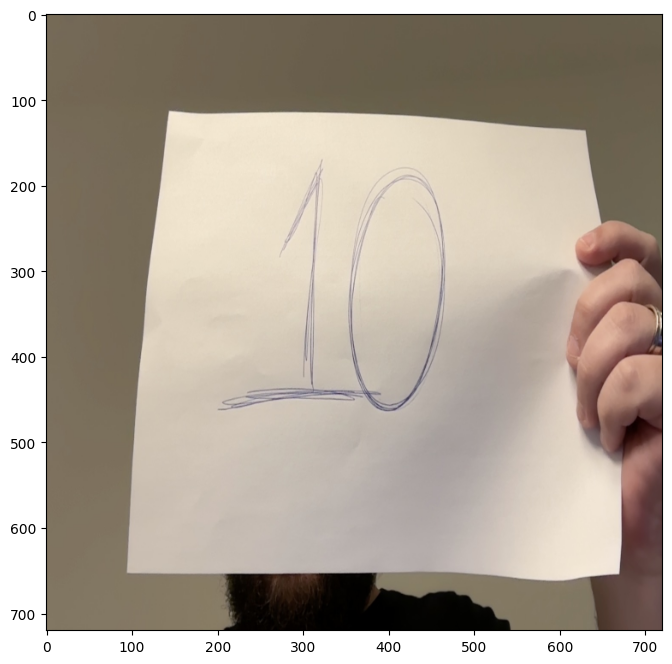

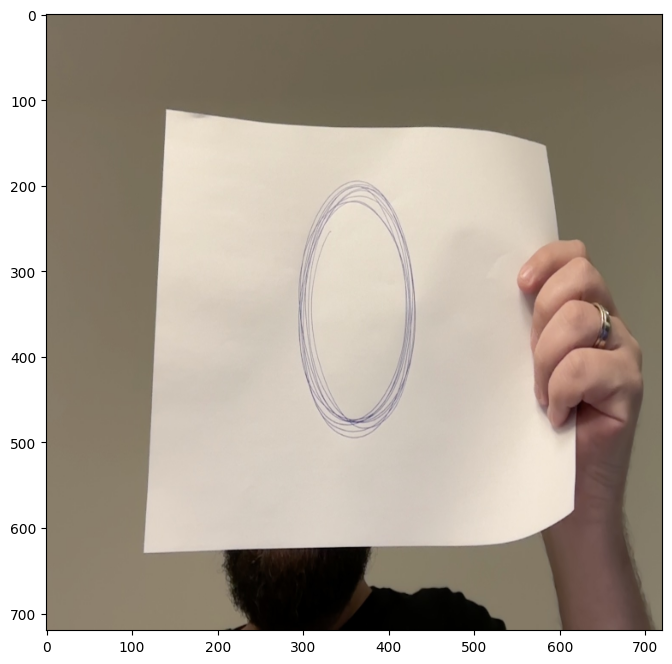

In [ ]:
# Load and preprocess sample image
image1 = loadAndPreprocessImage('aprovado.jpg')
image2 = loadAndPreprocessImage('reprovado.jpg')
printImage(image1)
printImage(image2)

## Definindo a função que consultará o modelo remotamente

In [ ]:
import requests

def send_image_to_model(file_path, endpoint, additional_data=None):
  """
  Uploads a file to the specified endpoint.
  :param endpoint: URL of the endpoint to which the file should be uploaded
  :param file_path: Path to the file to be uploaded
  :param additional_data: Dictionary of additional data to be sent with the file, if any
  :return: Response from the server
  """
  try:
    with open(file_path, 'rb') as file:
      files = {'file': (file_path, file)}
      data = additional_data if additional_data else {}
      response = requests.post(endpoint, files=files, data=data)
      return response.text
  except Exception as e:
    print(f"An error occurred: {e}")
    return None

In [ ]:
import requests

# def send_image_to_model(image_bytes, endpoint_url):

#     print(sys.getsizeof(image_bytes))

#     response = requests.post(endpoint_url, files={"file": image_bytes})

#     if response.status_code == 200:
#         print("Response received")
#         return response.text
#     else:
#         print(f"Failed to get a valid response. Status code: {response.status_code}")
#         return None

def get_formatted_response(http_response):
    response_dict = {}
    try:
      response_dict = json.loads(http_response)
    except Exception as e:
      print(http_response)
      return None

    class_name, confidence = response_dict['class'], response_dict['confidence']
    return class_name, confidence

def get_bytes_from_image(image_obj):
    buffer = io.BytesIO()
    image_obj.save(buffer, format='JPEG')  # Adjust format as needed (JPEG, PNG, etc.)
    image_bytes = buffer.getvalue()

    return image_bytes

In [ ]:
aprovado_image_path = 'aprovado.jpg'
reprovado_image_path = 'reprovado.jpg'
endpoint_url = 'http://ec2-3-93-177-0.compute-1.amazonaws.com:8080/classify'

image_bytes = get_bytes_from_image(image2)

response = send_image_to_model(aprovado_image_path, endpoint_url)
response_dict = json.loads(response)
print(response_dict)

{'class': 'aprovado\n', 'confidence': 0.9884340167045593}


## Realizando a inferência

In [ ]:
# response = send_image_to_model(get_bytes_from_image(image1), endpoint_url)

# class_name, confidence = get_formatted_response(response)

# printImage(image1, class_name, confidence)

In [ ]:
# response = send_image_to_model(get_bytes_from_image(image2), endpoint_url)

# class_name, confidence = get_formatted_response(response)

# printImage(image2, class_name, confidence)

# Ataques BlackBox

## Square Attack

In [ ]:
# adaptado de https://github.com/max-andr/square-attack
# artigo: https://arxiv.org/abs/1912.00049

import numpy as np
from tqdm import tqdm

class SquareAttack:
  def __init__(self,eps,n_iters,initial_p,initialization):
    self.eps = eps
    self.n_iters = n_iters
    self.initial_p = initial_p
    self.initialization = initialization

  # Seleciona o tamanho do quadrado de acordo com a iteração atual
  def p_selection(self,p_init,it,n_iters):
    it = int(it / n_iters * 10000)
    if 10 < it <= 50:
        p = p_init / 2
    elif 50 < it <= 200:
        p = p_init / 4
    elif 200 < it <= 500:
        p = p_init / 8
    elif 500 < it <= 1000:
        p = p_init / 16
    elif 1000 < it <= 2000:
        p = p_init / 32
    elif 2000 < it <= 4000:
        p = p_init / 64
    elif 4000 < it <= 6000:
        p = p_init / 128
    elif 6000 < it <= 8000:
        p = p_init / 256
    elif 8000 < it <= 10000:
        p = p_init / 512
    else:
        p = p_init
    return p

  def apply(self,image,y, attempt_n):
    _,h,w,c = image.shape
    n_features = c*h*w

    min_val,max_val = -1,1
    # preds = np.array(model.predict(image,verbose=0))[0]
    # y_pred = preds.argmax()
    # score = preds[y_pred]
    # tf.keras.preprocessing.image.save_img('sample.jpg', image[0])
    save_image_from_tensor(image, f'sample{attempt_n}.jpg')
    img = loadAndPreprocessImage(f'sample{attempt_n}.jpg')
    # response = send_image_to_model(get_bytes_from_image(img), endpoint_url)
    response = send_image_to_model(f'sample{attempt_n}.jpg', endpoint_url)
    y_pred, score = get_formatted_response(response)
    print(y_pred, score)

    X = image
    if self.initialization:
      init_delta = np.random.choice([-self.eps,self.eps],size=[1,w,c])
      X_best = tf.clip_by_value(image+init_delta,-1,1)
      pert = X_best-image
    else:
      X_best = image
      pert = X_best-image

    # tf.keras.preprocessing.image.save_img('sample.jpg', X_best[0])
    save_image_from_tensor(X_best, f'sample{attempt_n}.jpg')
    img = loadAndPreprocessImage(f'sample{attempt_n}.jpg')
    # response = send_image_to_model(get_bytes_from_image(img), endpoint_url)
    response = send_image_to_model(f'sample{attempt_n}.jpg', endpoint_url)
    y_pred, score = get_formatted_response(response)
    print(y_pred, score)
    # preds = np.array(model.predict(X_best,verbose=0))[0]
    # y_pred = preds.argmax()

    if y_pred != y:  # classe prevista diferente da real, retorna
      return 1,X_best, pert, y_pred, score

    # score = preds[y_pred]
    loss_min = score

    for i_iter in range(self.n_iters-1):
      print(f'iteration {i_iter}')
      to_fool = loss_min >= 0.5

      if to_fool:
        X_curr,X_best_curr = X,X_best
        loss_min_curr = loss_min
        delta = (X_best_curr-X_curr).numpy()
        p = self.p_selection(self.initial_p,i_iter,self.n_iters)
        s = int(round(np.sqrt(p*n_features/c)))
        s = min(max(s,1),h-1)

        # Escolhe um centro aleatório para o quadrado
        center_h = np.random.randint(0,max(h-s,1))
        center_w = np.random.randint(0,max(w-s,1))

        x_curr_window = X_curr[:,center_h:center_h+s,center_w:center_w+s,:]
        X_best_curr_window = X_best_curr[:,center_h:center_h+s,center_w:center_w+s,:]

        # Gera uma perturbação aleatória no quadrado
        delta[:,center_h:center_h+s,center_w:center_w+s,:] = np.random.choice([-self.eps,self.eps],size=[1,1,c])

        X_new = tf.clip_by_value(X_curr+delta,-1,1)

        # tf.keras.preprocessing.image.save_img('sample.jpg', X_new[0])
        save_image_from_tensor(X_new, f'sample{attempt_n}.jpg')
        img = loadAndPreprocessImage(f'sample{attempt_n}.jpg')
        # response = send_image_to_model(get_bytes_from_image(img), endpoint_url)
        response = send_image_to_model(f'sample{attempt_n}.jpg', endpoint_url)
        y_pred, score = get_formatted_response(response)
        print(y_pred, score)
        # preds = np.array(model.predict(X_new,verbose=0))[0]
        # y_pred = preds.argmax()
        # score = preds[y_pred]

        if y_pred != y: # classe prevista diferente da real, retorna
          return i_iter,X_new, (pert+delta), y_pred, score

        if score < loss_min:
          loss_min = score
          X_best = X_new
          pert += delta
    return self.n_iters, X_best, pert, y_pred, score

### Primeira tentativa

In [ ]:
attack = SquareAttack(eps=0.02, n_iters=600, initial_p=0.5, initialization=True)
n_iters, perturbed_image, pert, class_name, confidence = attack.apply(preprocess(image2), "reprovado\n", 1)
print(f"Número de iterações necessárias: {n_iters}")

reprovado
 0.9993390440940857
reprovado
 0.9973125457763672
iteration 0
reprovado
 0.9993131160736084
iteration 1
reprovado
 0.9983518123626709
iteration 2
reprovado
 0.9990921020507812
iteration 3
reprovado
 0.9981512427330017
iteration 4
reprovado
 0.996232807636261
iteration 5
reprovado
 0.9978803396224976
iteration 6
reprovado
 0.9972112774848938
iteration 7
reprovado
 0.9979458451271057
iteration 8
reprovado
 0.9973973035812378
iteration 9
reprovado
 0.9967365860939026
iteration 10
reprovado
 0.9982361793518066
iteration 11
reprovado
 0.9961066842079163
iteration 12
reprovado
 0.9981884360313416
iteration 13
reprovado
 0.9947605729103088
iteration 14
reprovado
 0.9965930581092834
iteration 15
reprovado
 0.9938256740570068
iteration 16
reprovado
 0.9948337078094482
iteration 17
reprovado
 0.9925873875617981
iteration 18
reprovado
 0.995081901550293
iteration 19
reprovado
 0.9932295083999634
iteration 20
reprovado
 0.9923978447914124
iteration 21
reprovado
 0.9924140572547913
iterat

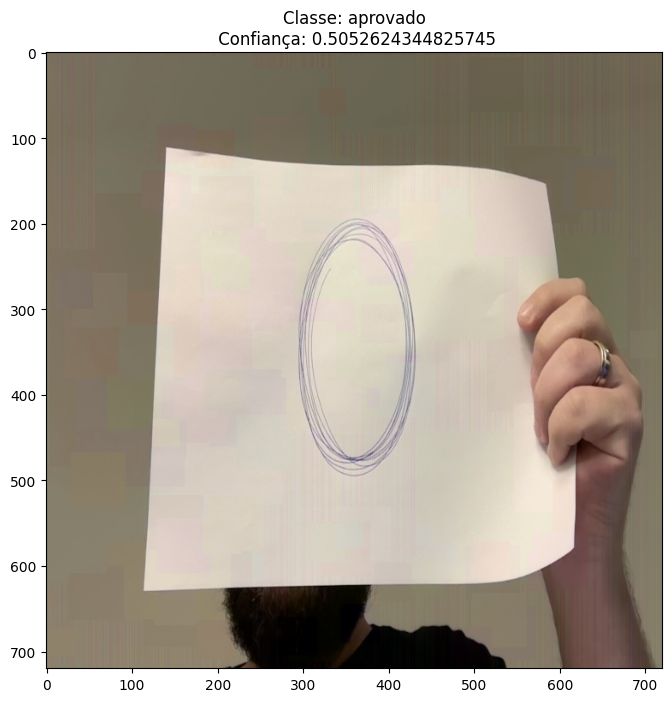

In [ ]:
printImage(perturbed_image, class_name, confidence, preprocessed=True)

### Segunda tentativa

In [ ]:
attack = SquareAttack(eps=0.04, n_iters=600, initial_p=0.5, initialization=True)
n_iters2, perturbed_image2, pert2, class_name2, confidence2 = attack.apply(preprocess(image2), "reprovado\n", 2)
print(f"Número de iterações necessárias: {n_iters2}")

reprovado
 0.9993390440940857
reprovado
 0.9991587400436401
iteration 0
reprovado
 0.9991757273674011
iteration 1
reprovado
 0.9997760653495789
iteration 2
reprovado
 0.9997109770774841
iteration 3
reprovado
 0.9995614886283875
iteration 4
reprovado
 0.9966051578521729
iteration 5
reprovado
 0.9995853304862976
iteration 6
reprovado
 0.9983471632003784
iteration 7
reprovado
 0.9995834231376648
iteration 8
reprovado
 0.9994012117385864
iteration 9
reprovado
 0.9982742071151733
iteration 10
reprovado
 0.9996015429496765
iteration 11
reprovado
 0.9993667006492615
iteration 12
reprovado
 0.9995394945144653
iteration 13
reprovado
 0.998576283454895
iteration 14
reprovado
 0.9954604506492615
iteration 15
reprovado
 0.990638256072998
iteration 16
reprovado
 0.995864987373352
iteration 17
reprovado
 0.9969454407691956
iteration 18
reprovado
 0.9918659329414368
iteration 19
reprovado
 0.994181215763092
iteration 20
reprovado
 0.9969643950462341
iteration 21
reprovado
 0.9931657910346985
iteratio

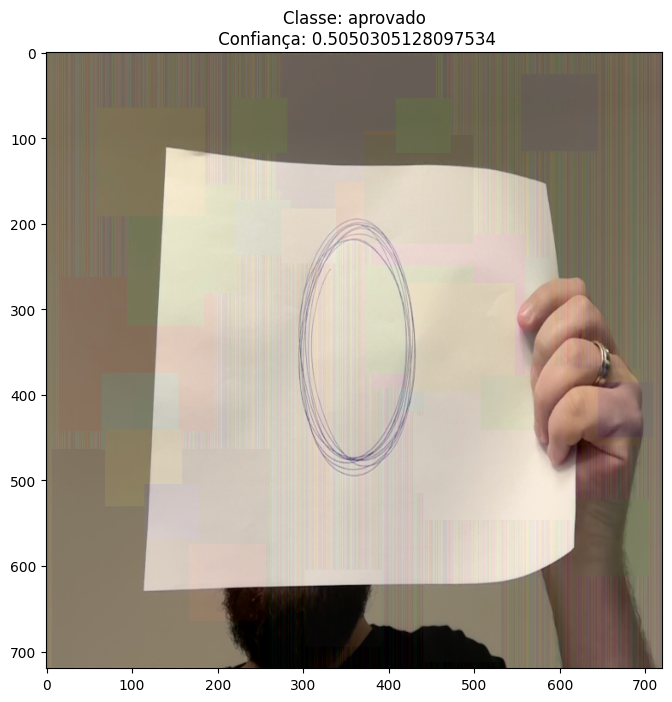

In [ ]:
printImage(perturbed_image2, class_name2, confidence2, preprocessed=True)

### Terceira tentativa

In [ ]:
attack = SquareAttack(eps=0.06, n_iters=600, initial_p=0.5, initialization=True)
n_iters3, perturbed_image3, pert3, class_name3, confidence3 = attack.apply(preprocess(image2), "reprovado\n", 3)
print(f"Número de iterações necessárias: {n_iters3}")

reprovado
 0.9993390440940857
reprovado
 0.9963480830192566
iteration 0
reprovado
 0.9998968839645386
iteration 1
reprovado
 0.9998878240585327
iteration 2
reprovado
 0.9998683929443359
iteration 3
reprovado
 0.9998494386672974
iteration 4
reprovado
 0.9987236857414246
iteration 5
reprovado
 0.9884850978851318
iteration 6
reprovado
 0.9991959929466248
iteration 7
reprovado
 0.9982996582984924
iteration 8
reprovado
 0.9960716962814331
iteration 9
reprovado
 0.9879292249679565
iteration 10
reprovado
 0.9999421834945679
iteration 11
reprovado
 0.9938510656356812
iteration 12
reprovado
 0.9988839030265808
iteration 13
reprovado
 0.9734516739845276
iteration 14
reprovado
 0.9815545678138733
iteration 15
reprovado
 0.9639689326286316
iteration 16
reprovado
 0.9833133816719055
iteration 17
reprovado
 0.9990804195404053
iteration 18
reprovado
 0.8958935737609863
iteration 19
reprovado
 0.9563973546028137
iteration 20
reprovado
 0.8974260091781616
iteration 21
reprovado
 0.9978204965591431
iter

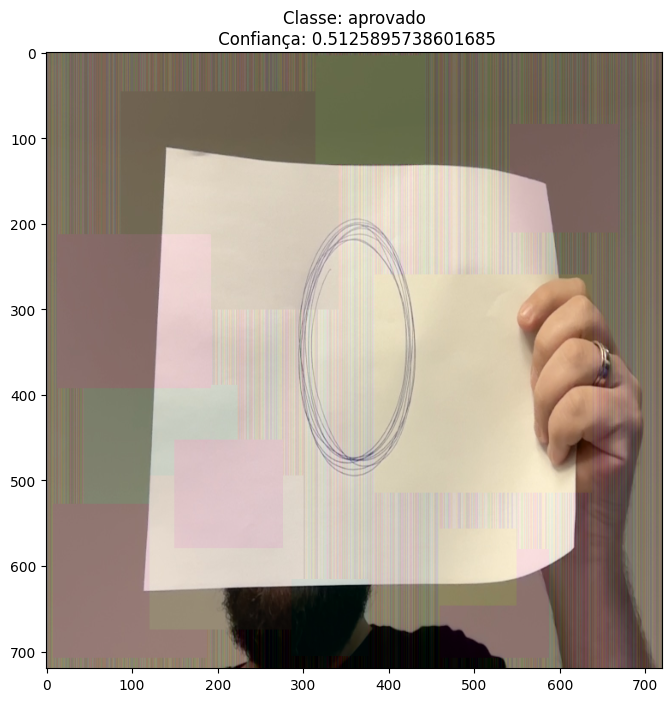

In [ ]:
printImage(perturbed_image3, class_name3, confidence3, preprocessed=True)

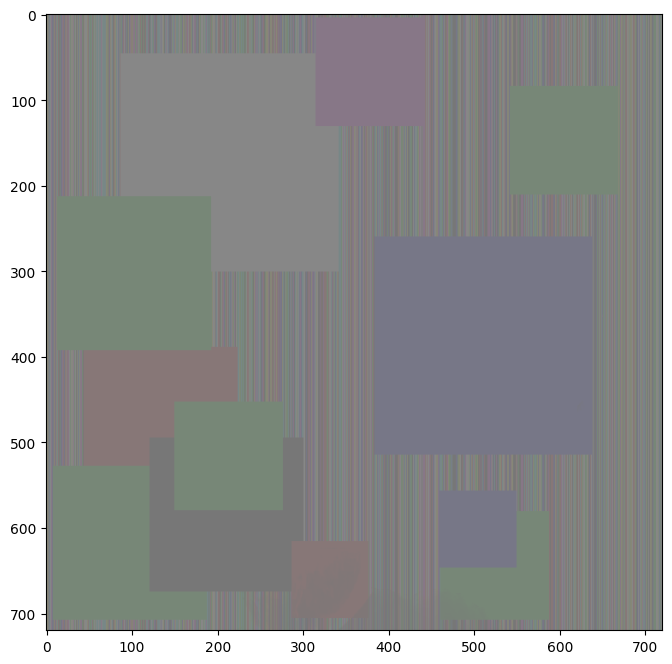

In [ ]:
printImage(preprocess(image2) - perturbed_image3, preprocessed=True)

In [ ]:
attack = SquareAttack(eps=0.01, n_iters=1600, initial_p=0.5, initialization=True)
n_iters4, perturbed_image4, pert4, class_name4, confidence4 = attack.apply(preprocess(image2), "reprovado\n", 4)
print(f"Número de iterações necessárias: {n_iters4}")

reprovado
 0.9993390440940857
reprovado
 0.9987727999687195
iteration 0
reprovado
 0.9995423555374146
iteration 1
reprovado
 0.9990875720977783
iteration 2
reprovado
 0.9987898468971252
iteration 3
reprovado
 0.9985837936401367
iteration 4
reprovado
 0.9991590976715088
iteration 5
reprovado
 0.9981430768966675
iteration 6
reprovado
 0.9990100860595703
iteration 7
reprovado
 0.9992807507514954
iteration 8
reprovado
 0.9990541338920593
iteration 9
reprovado
 0.9981757402420044
iteration 10
reprovado
 0.998369038105011
iteration 11
reprovado
 0.9989008903503418
iteration 12
reprovado
 0.9986342787742615
iteration 13
reprovado
 0.998384952545166
iteration 14
reprovado
 0.99798583984375
iteration 15
reprovado
 0.997911274433136
iteration 16
reprovado
 0.9982364177703857
iteration 17
reprovado
 0.9980803728103638
iteration 18
reprovado
 0.9976567029953003
iteration 19
reprovado
 0.9977206587791443
iteration 20
reprovado
 0.9980612397193909
iteration 21
reprovado
 0.9991447925567627
iteration

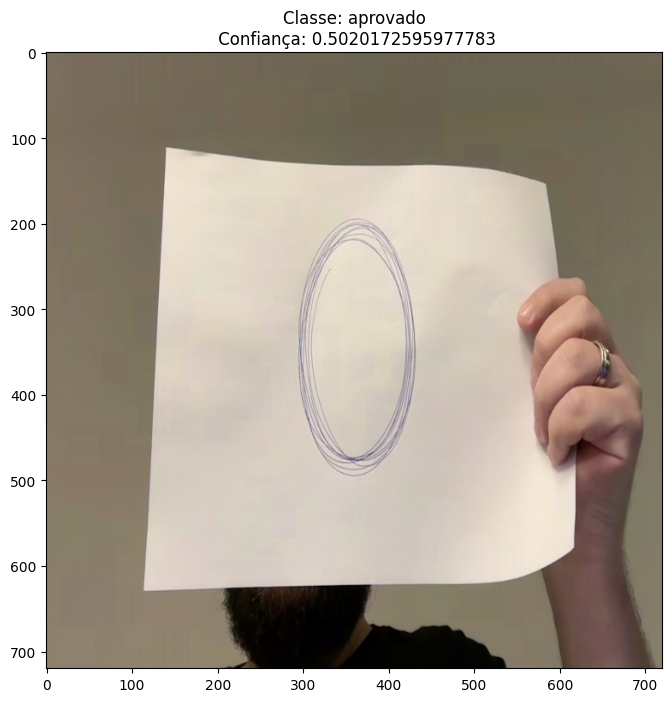

In [ ]:
printImage(perturbed_image4, class_name4, confidence4, preprocessed=True)

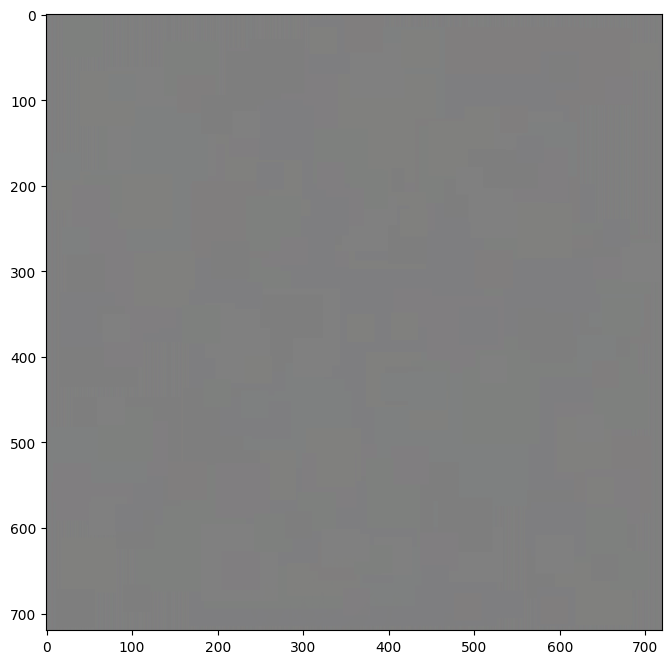

In [ ]:
printImage(preprocess(image2) - perturbed_image4, preprocessed=True)